# Task 3 — SHAP Explainability (Single Notebook)

This notebook:
- Loads **processed** fraud dataset (`data/processed/fraud_data_processed.csv`)
- Loads an existing **best model pipeline** (if available) OR trains a **Random Forest pipeline**
- Evaluates with **AUC-PR**, **F1**, and **Confusion Matrix**
- Produces **built-in feature importance** and **SHAP** explanations
- Generates **3 individual explanations**: TP, FP, FN

**Expected repo paths**:
- `../data/processed/fraud_data_processed.csv`
- (optional) `../models/best_model.pkl`


In [ ]:

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import average_precision_score, f1_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import shap
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


: 

## 1) Load processed data

In [2]:
data_path = "../data/processed/fraud_data_processed.csv"
assert os.path.exists(data_path), f"Missing file: {data_path}. Create it in Task-1 first."

df = pd.read_csv(data_path)
print("Shape:", df.shape)
display(df.head())


Shape: (151112, 22)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,time_since_signup_seconds,time_since_signup_hours,hour_of_day,day_of_week,user_tx_count_total,users_per_device,devices_per_user,lower_bound_ip_address,upper_bound_ip_address,country
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093.496895,...,1763014.0,489.726111,10,6,1,1,1,2.163769e+09,2.163835e+09,Unknown
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447.138961,...,1084823.0,301.339722,17,4,1,1,1,2.163769e+09,2.163835e+09,Unknown
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818.501505,...,749320.0,208.144444,8,1,1,1,1,2.163769e+09,2.163835e+09,Unknown
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566.664867,...,7434634.0,2065.176111,21,3,1,1,1,2.163769e+09,2.163835e+09,Unknown
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423.789042,...,1407619.0,391.005278,7,6,1,1,1,2.163769e+09,2.163835e+09,Unknown


In [3]:
# Target and features
target_col = "class"
assert target_col in df.columns, f"Target column '{target_col}' not found."

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

print("Fraud rate:", y.mean())
print("Class counts:\n", y.value_counts())


Fraud rate: 0.09364577267192546
Class counts:
 class
0    136961
1     14151
Name: count, dtype: int64


## 2) Train-test split (stratified)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train fraud rate:", y_train.mean())
print("Test fraud rate:", y_test.mean())


Train fraud rate: 0.09364789186774644
Test fraud rate: 0.09363729609899746


## 3) Load best model if available (or train a strong default)
This expects a **Pipeline** with steps: `preprocess` and `model`.

In [5]:
model_path = "../models/best_model.pkl"

# Build preprocessing
num_cols = X_train.select_dtypes(include="number").columns
cat_cols = X_train.select_dtypes(exclude="number").columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

if os.path.exists(model_path):
    print("Loading existing model:", model_path)
    model = joblib.load(model_path)
else:
    print("No saved model found. Training a default RandomForest pipeline...")
    model = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=300,
            max_depth=12,
            class_weight="balanced",
            n_jobs=-1,
            random_state=RANDOM_STATE
        ))
    ])
    model.fit(X_train, y_train)

    os.makedirs("../models", exist_ok=True)
    joblib.dump(model, model_path)
    print("Saved trained model to:", model_path)

model


No saved model found. Training a default RandomForest pipeline...
Saved trained model to: ../models/best_model.pkl


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['user_id', 'purchase_value', 'age', 'ip_address', 'ip_int',
       'time_since_signup_seconds', 'time_since_signup_hours', 'hour_of_day',
       'day_of_week', 'user_tx_count_total', 'users_per_device',
       'devices_per_user', 'lower_bound_ip_address', 'upper_bound_ip_address'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['signup_time', 'purchase_time', 'device_id', 'source', 'browser', 'sex',
       'country'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=12,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

## 4) Evaluate model (AUC-PR, F1, Confusion Matrix)

In [6]:
# Probabilities for PR-AUC
if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_test)[:, 1]
else:
    # fallback: use decision_function then min-max scale
    scores = model.decision_function(X_test)
    y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)

y_pred = model.predict(X_test)

auc_pr = average_precision_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("AUC-PR:", auc_pr)
print("F1:", f1)
print("Confusion Matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))


AUC-PR: 0.6975174999253132
F1: 0.6758527219335894
Confusion Matrix:
 [[27292   101]
 [ 1334  1496]]

Classification report:
               precision    recall  f1-score   support

           0     0.9534    0.9963    0.9744     27393
           1     0.9368    0.5286    0.6759      2830

    accuracy                         0.9525     30223
   macro avg     0.9451    0.7625    0.8251     30223
weighted avg     0.9518    0.9525    0.9464     30223



## 5) Built-in feature importance (tree models)
If your chosen model is a tree ensemble (RF/XGBoost/LightGBM), show top 10 importances.

,feature,importance
5,num__time_since_signup_seconds,0.026151
6,num__time_since_signup_hours,0.021337
10,num__users_per_device,0.010133
8,num__day_of_week,0.009713
352837,cat__source_Direct,0.004331
272377,cat__device_id_HGVNRPOHIBZLJ,0.004246
286487,cat__device_id_KPAAACGRQWYIK,0.004183
7,num__hour_of_day,0.003958
253899,cat__device_id_CXICHNYDPUZNN,0.003915
4,num__ip_int,0.003903


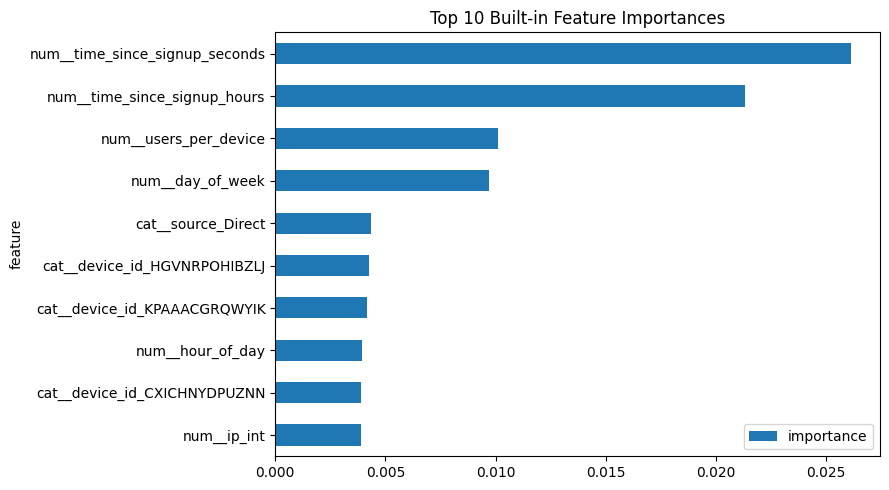

In [7]:
# Extract fitted model + transformed feature names (works for sklearn Pipeline)
preprocess = model.named_steps.get("preprocess")
clf = model.named_steps.get("model")

feature_names = None
if preprocess is not None and hasattr(preprocess, "get_feature_names_out"):
    feature_names = preprocess.get_feature_names_out()

if hasattr(clf, "feature_importances_") and feature_names is not None:
    importances = clf.feature_importances_
    fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)

    display(fi.head(10))

    ax = fi.head(10).sort_values("importance").plot.barh(x="feature", y="importance", figsize=(9, 5))
    ax.set_title("Top 10 Built-in Feature Importances")
    plt.tight_layout()
    plt.show()
else:
    print("Built-in feature importance not available for this model type or feature names missing.")


## 6) SHAP Global Explanation (Summary Plot)
For tree models, use `shap.TreeExplainer`. For other models, we try `shap.Explainer` as fallback.

⚠️ SHAP needs the **transformed feature matrix** from preprocessing.

In [8]:
# Transform features (sparse -> dense if needed)
X_test_trans = preprocess.transform(X_test) if preprocess is not None else X_test

# Convert sparse matrices to dense for SHAP plots if necessary
try:
    import scipy.sparse as sp
    if sp.issparse(X_test_trans):
        X_test_trans_dense = X_test_trans.toarray()
    else:
        X_test_trans_dense = np.asarray(X_test_trans)
except Exception:
    X_test_trans_dense = np.asarray(X_test_trans)

if feature_names is None:
    # Fallback generic names
    feature_names = [f"f{i}" for i in range(X_test_trans_dense.shape[1])]

# Choose explainer
try:
    if hasattr(clf, "feature_importances_"):
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_test_trans_dense)
        # For binary classification, many explainers return list [class0, class1]
        shap_vals_fraud = shap_values[1] if isinstance(shap_values, list) else shap_values
        expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
    else:
        explainer = shap.Explainer(clf, X_test_trans_dense)
        shap_expl = explainer(X_test_trans_dense)
        shap_vals_fraud = shap_expl.values
        expected_value = shap_expl.base_values
    print("SHAP explainer:", type(explainer).__name__)
except Exception as e:
    raise RuntimeError(f"Failed to build SHAP explainer: {e}")

# Summary plot (Top 10)
shap.summary_plot(
    shap_vals_fraud,
    X_test_trans_dense,
    feature_names=feature_names,
    max_display=10,
    show=True
)


RuntimeError: Failed to build SHAP explainer: setting an array element with a sequence.

## 7) SHAP Individual Explanations (TP, FP, FN)
We find one example of each case and generate a force plot.

If a case doesn't exist (rare depending on threshold/model), the cell will tell you.

In [9]:
# Get predictions on test set for case selection
y_pred_test = model.predict(X_test)
y_true_test = y_test.reset_index(drop=True)

# Build indices relative to X_test order
tp_candidates = np.where((y_true_test.values == 1) & (y_pred_test == 1))[0]
fp_candidates = np.where((y_true_test.values == 0) & (y_pred_test == 1))[0]
fn_candidates = np.where((y_true_test.values == 1) & (y_pred_test == 0))[0]

def explain_one(idx, title):
    print("\n" + "="*80)
    print(title, "| test row idx:", idx)
    print("="*80)
    # Force plot with matplotlib=True for static rendering in notebooks
    shap.force_plot(
        expected_value,
        shap_vals_fraud[idx],
        X_test_trans_dense[idx],
        feature_names=feature_names,
        matplotlib=True,
        show=True
    )
    plt.show()

if len(tp_candidates) > 0:
    explain_one(int(tp_candidates[0]), "TRUE POSITIVE (Fraud correctly detected)")
else:
    print("No TRUE POSITIVE example found in test set.")

if len(fp_candidates) > 0:
    explain_one(int(fp_candidates[0]), "FALSE POSITIVE (Legit transaction flagged as fraud)")
else:
    print("No FALSE POSITIVE example found in test set.")

if len(fn_candidates) > 0:
    explain_one(int(fn_candidates[0]), "FALSE NEGATIVE (Fraud missed)")
else:
    print("No FALSE NEGATIVE example found in test set.")



TRUE POSITIVE (Fraud correctly detected) | test row idx: 17


NameError: name 'expected_value' is not defined

## 8) Write-up guidance (paste into your report)
Use these prompts to write your interpretation:

- **Top 5 drivers**: From SHAP summary, list the top 5 features.
- **Direction**: For each, explain how high/low values move predictions.
- **Compare** built-in importance vs SHAP (what differs?).
- **Recommendations (at least 3)**: Tie directly to SHAP findings.

Example recommendation patterns:
- Very short `time_since_signup_hours` → step-up verification for new accounts.
- High `users_per_device` → review devices shared across many users.
- Risky `country`/late-night `hour_of_day` combinations → stronger authentication.
